<a href="https://colab.research.google.com/github/ManelSoengas/DL_Task2/blob/main/DL_task2_Robertuito_21_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis del carácter sexista de tweets en idioma Español. Se utiliza el modelo preentrenado Robertuito.**

##<font color='brown'>**Carga de los datos**</font>

1. Conjunto de datos train y test compuesto por tweets en Español.
2. Al conjunto train se añaden los tweets en inglés traducidos al Español en alguna de las pruebas.
3. Se aplica el modelo con la opción 2 y sin ella a las tareas de clasificación para la clase objetivo task1 y task2.

In [1]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

import pandas as pd

# Leer los archivos TSV y seleccionar las columnas deseadas y filtrar por idioma 'es'
test = pd.read_csv('/content/EXIST2021_test_labeled.tsv', sep='\t', usecols=['text', 'language', 'task1']).loc[lambda df: df['language'] == 'es']
train_data = pd.read_csv('/content/EXIST2021_training.tsv', sep='\t', usecols=['text', 'language', 'task1']).loc[lambda df: df['language'] == 'es']
train_data_en = pd.read_csv('/content/train_data_translated_from_en_to_es.csv', sep=',', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'en']
swapp = pd.read_csv('/content/swapp_EXIST2021_training.tsv', sep='\t', usecols=['text', 'language', 'task1']).loc[lambda df: df['language'] == 'es']

In [2]:

# Lista de categorías que se convertirán a "sexist"
sexist_categories = [
    "ideological-inequality",
    "misogyny-non-sexual-violence",
    "stereotyping-dominance",
    "sexual-violence",
    "objectification"
]

# Función para realizar la conversión y reemplazo
def convert_and_replace(category):
    if category in sexist_categories:
        return "sexist"
    elif category == "non-sexist":
        return "non-sexist"
    else:
        return category

# Aplicar la función a la columna 'task2' del DataFrame
train_data_en['task1'] = train_data_en['task2'].apply(convert_and_replace)



In [ ]:
train_data_en.head(10)


In [3]:
# Concatenar train_data y train_data_en en un único DataFrame llamado train_data
train_data = pd.concat([train_data, train_data_en], ignore_index=True)
train_data = shuffle(train_data, random_state=42)

# Verificar el resultado
print(train_data.head())


     language                                               text       task1  \
5286       en  El pastel de cumpleaños de @summeryea es una d...  non-sexist   
6018       en  @JoshHarris91 @unitedwarrior6 @Kevwafc19701 @F...  non-sexist   
2981       es  @erickatr @itextosoff Enamore con su intelecto...      sexist   
3347       es  @Chax12908518 @loanyrumex @S41000318S @CCorp18...  non-sexist   
469        es                @perra_amargada  que vas a hacer???  non-sexist   

           task2  
5286  non-sexist  
6018  non-sexist  
2981         NaN  
3347         NaN  
469          NaN  


In [4]:
# Concatenar train_data y train_data_en en un único DataFrame llamado train_data
train_data = pd.concat([train_data, swapp], ignore_index=True)
train_data = shuffle(train_data, random_state=42)

# Verificar el resultado
print(train_data.head())

     language                                               text       task1  \
811        es  @Rodrigo30815714 Y como tiene que ser una seño...      sexist   
5945       es  Me da una felicidad enorme que finalmente sea ...      sexist   
353        en  @BBCJohnBeattie @BBCRadioScot Aquí hay una pre...      sexist   
3409       es  Hoy mando a comer mlerda a todita la organizac...      sexist   
4900       en  @getrwuegyweh te hiciste ver como un idiota, m...  non-sexist   

                       task2  
811                      NaN  
5945                     NaN  
353   ideological-inequality  
3409                     NaN  
4900              non-sexist  


In [5]:
# Seleccionar solo las columnas 'text' y 'task2'
test = test[['text', 'task1']]
train_data = train_data[['text', 'task1']]

##<font color='brown'>**Adaptar el dataset a las características del modelo**</font>

In [6]:
# Cambiar el nombre de la columna 'task2' a 'label'
test.rename(columns={'task1': 'label'}, inplace=True)
train_data.rename(columns={'task1': 'label'}, inplace=True)

##<font color='brown'>**Estructura y organización de la clase objetivo**</font>

In [7]:
columna_clase_objetivo = "label"

df = train_data

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 2
Muestras por categoría:
non-sexist    6676
sexist        6342
Name: label, dtype: int64


13018

In [8]:
columna_clase_objetivo = "label"

df = test

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 2
Muestras por categoría:
sexist        1123
non-sexist    1037
Name: label, dtype: int64


2160

##<font color='brown'>**Creación de los conjuntos de datos**</font>
1. Asignación de las muestras para los conjuntos de dtos train y validación.
2. Visualización del número de muestras.

In [9]:
from sklearn.model_selection import train_test_split

# Dividir train_data en train y validation (80% train, 20% validation)
train, validation = train_test_split(train_data, test_size=0.2, random_state=42)

# Obtener el número total de muestras en cada conjunto
total_train_samples = train.shape[0]
total_validation_samples = validation.shape[0]
total_test_samples = test.shape[0]

print("Total de muestras en el conjunto de entrenamiento:", total_train_samples)
print("Total de muestras en el conjunto de validación:", total_validation_samples)
print("Total de muestras en el conjunto de test:", total_test_samples)

Total de muestras en el conjunto de entrenamiento: 10414
Total de muestras en el conjunto de validación: 2604
Total de muestras en el conjunto de validación: 2160


##<font color='brown'>**Tarea 2.Task2**</font>

Conversión de las categorias, de la clase objetivo, de string a numéricas.

In [ ]:
# Definir la función de conversión de etiquetas
def convert_labels(label):
    label_mapping = {
        "non-sexist": 0,
        "ideological-inequality": 1,
        "misogyny-non-sexual-violence": 2,
        "stereotyping-dominance": 3,
        "sexual-violence": 4,
        "objectification": 5
    }
    return label_mapping.get(label, -1)  # Devolver -1 para etiquetas no esperadas

# Convertir las etiquetas en los DataFrames
train['label'] = train['label'].apply(convert_labels)
validation['label'] = validation['label'].apply(convert_labels)
test['label'] = test['label'].apply(convert_labels)

##<font color='brown'>**Tarea 1. Task1**</font>
Conversión de las categorias, de la clase objetivo, de string a numéricas.

In [10]:
# Definir la función de conversión de etiquetas
def convert_labels(label):
    label_mapping = {
        "non-sexist": 0,
        "sexist": 1
        }
    return label_mapping.get(label, -1)  # Devolver -1 para etiquetas no esperadas

# Convertir las etiquetas en los DataFrames
train['label'] = train['label'].apply(convert_labels)
validation['label'] = validation['label'].apply(convert_labels)
test['label'] = test['label'].apply(convert_labels)

In [11]:
import pandas as pd

# Ejemplo con el conjunto de entrenamiento
print(train.head())  # Muestra las primeras filas del DataFrame
print(train['label'].dtype)  # Muestra el tipo de dato de la columna 'label'


                                                    text  label
468    Miranda Cosgrove paso de ser una perra mala a ...      1
11153  FMCREM @ NoticiasCaracol @ Pues hasta yo sé lo...      1
1604   Es realmente una mierda que las personas perci...      0
9277   “ Te vez muy mojigata para pedir algo tan vulg...      1
4812   Los tíos demostrando que tb pueden ser incongr...      1
int64


In [12]:
import pandas as pd

# Ejemplo con el conjunto de entrenamiento
print(test.head())  # Muestra las primeras filas del DataFrame
print(test['label'].dtype)  # Muestra el tipo de dato de la columna 'label'


                                                   text  label
2208                      Y te golpeo más fuerte perra.      1
2209  @wthxtme @GOLDENMXM Castigado tres meses sin s...      0
2210  @MaricaIndomito jajajaj el me he topado con ta...      1
2211  Resulta que hoy es el día de la juventud y no ...      0
2212  @EstefMolina_ Los que dicen que creen en la ig...      1
int64


In [13]:
train.head(10)

,text,label
468,Miranda Cosgrove paso de ser una perra mala a ...,1
11153,FMCREM @ NoticiasCaracol @ Pues hasta yo sé lo...,1
1604,Es realmente una mierda que las personas perci...,0
9277,“ Te vez muy mojigata para pedir algo tan vulg...,1
4812,Los tíos demostrando que tb pueden ser incongr...,1
8570,Putas jonas pichas https://t.co/6digVe6f9g,1
8990,"@Esgueva3 @david_deivis Pero entonces, él hemb...",1
598,@IncelsCo saben que las prostitutas comunes ah...,1
466,SPOILER!!!Las mujeres no somos centro de rehab...,1
5992,Animal by neon trees estaba MUY adelantado a s...,0


##<font color='brown'>**Dataset**</font>

Conversión de los dataframe a Dataset y facilitar el procesado de los datos por parte del modelo.

In [14]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.5 MB/s eta 0:00:00


In [15]:
from datasets import Dataset, DatasetDict

# Supongamos que tienes tres DataFrames: train_data, val_data y test_data

# Crear Dataset a partir de los DataFrames
train = Dataset.from_pandas(train)
validation = Dataset.from_pandas(validation)
test = Dataset.from_pandas(test)

# Crear DatasetDict similar a load_dataset
ds = DatasetDict({
    "train": train,
    "validation": validation,
    "test": test
})





In [16]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 5581
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1396
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2160
    })
})

In [ ]:
ds["test"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

##<font color='brown'>**Carga del modelo**</font>

In [16]:
!pip install pysentimiento transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=4c7b85fcdc9244e31fb0aae832791642a9c4b821cb832ffcb12c5aa7f33d096e
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "pysentimiento/robertuito-base-uncased"
# Crear una nueva configuración para el modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##<font color='brown'>**Preprocesado y tokenizado**</font>

In [18]:
from pysentimiento.preprocessing import preprocess_tweet
preprocessed_ds = ds.map(lambda ex: {"text": preprocess_tweet(ex["text"], lang="es")})

Map:   0%|          | 0/10414 [00:00<?, ? examples/s]

Map:   0%|          | 0/2604 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

In [19]:
tokenized_ds = preprocessed_ds.map(
    lambda batch: tokenizer(batch["text"], padding=True, truncation=True),
    batched=True, batch_size=32
)

Map:   0%|          | 0/10414 [00:00<?, ? examples/s]

Map:   0%|          | 0/2604 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

In [21]:
tokenized_ds = ds.map(
    lambda batch: tokenizer(batch["text"], padding=True, truncation=True),
    batched=True, batch_size=32
)

Map:   0%|          | 0/5581 [00:00<?, ? examples/s]

Map:   0%|          | 0/1396 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

In [20]:
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


##<font color='brown'>**Métricas de evaluación**</font>

In [21]:
import numpy as np
import evaluate

f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)

    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="macro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="macro"))
    return results

##<font color='brown'>**Entrenamiento**</font>

In [22]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

#Introducido weight_decay =0.01 y learning_rate = 1e-5
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    output_dir="test_trainer",
    do_eval=True,
    evaluation_strategy="epoch",
    num_train_epochs=5,


)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)
trainer.train()
# Entrenar el modelo utilizando la función de pérdida personalizada


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4287, 'learning_rate': 4.231950844854071e-05, 'epoch': 0.77}
{'eval_loss': 0.28115761280059814, 'eval_f1': 0.8863093429464013, 'eval_recall': 0.886421469577369, 'eval_runtime': 13.4422, 'eval_samples_per_second': 193.718, 'eval_steps_per_second': 24.252, 'epoch': 1.0}
{'loss': 0.2045, 'learning_rate': 3.4639016897081416e-05, 'epoch': 1.54}
{'eval_loss': 0.3857676088809967, 'eval_f1': 0.9105221546638917, 'eval_recall': 0.9108624938625978, 'eval_runtime': 15.3656, 'eval_samples_per_second': 169.469, 'eval_steps_per_second': 21.216, 'epoch': 2.0}
{'loss': 0.0899, 'learning_rate': 2.6958525345622122e-05, 'epoch': 2.3}
{'eval_loss': 0.5143325924873352, 'eval_f1': 0.9143214666856115, 'eval_recall': 0.9142899969785097, 'eval_runtime': 13.4567, 'eval_samples_per_second': 193.51, 'eval_steps_per_second': 24.226, 'epoch': 3.0}
{'loss': 0.0351, 'learning_rate': 1.927803379416283e-05, 'epoch': 3.07}
{'loss': 0.0093, 'learning_rate': 1.1597542242703534e-05, 'epoch': 3.84}
{'eval_loss': 0

TrainOutput(global_step=3255, training_loss=0.11896813933933569, metrics={'train_runtime': 1195.97, 'train_samples_per_second': 43.538, 'train_steps_per_second': 2.722, 'train_loss': 0.11896813933933569, 'epoch': 5.0})

##<font color='brown'>**Evaluación**</font>

In [23]:
trainer.evaluate(tokenized_ds["test"])

{'eval_loss': 1.4832550287246704, 'eval_f1': 0.7999890254609306, 'eval_recall': 0.8015655819281422, 'eval_runtime': 11.5343, 'eval_samples_per_second': 187.268, 'eval_steps_per_second': 23.408, 'epoch': 5.0}


{'eval_loss': 1.4832550287246704,
 'eval_f1': 0.7999890254609306,
 'eval_recall': 0.8015655819281422,
 'eval_runtime': 11.5343,
 'eval_samples_per_second': 187.268,
 'eval_steps_per_second': 23.408,
 'epoch': 5.0}

##<font color='brown'>**Matriz de confusión**</font>

In [24]:
class_names = [
    "non-sexist",
    "sexist"
]

In [ ]:
 class_names = [
        "non-sexist",
        "ideological-inequality",
        "misogyny-non-sexual-violence",
        "stereotyping-dominance",
        "sexual-violence",
        "objectification"
 ]

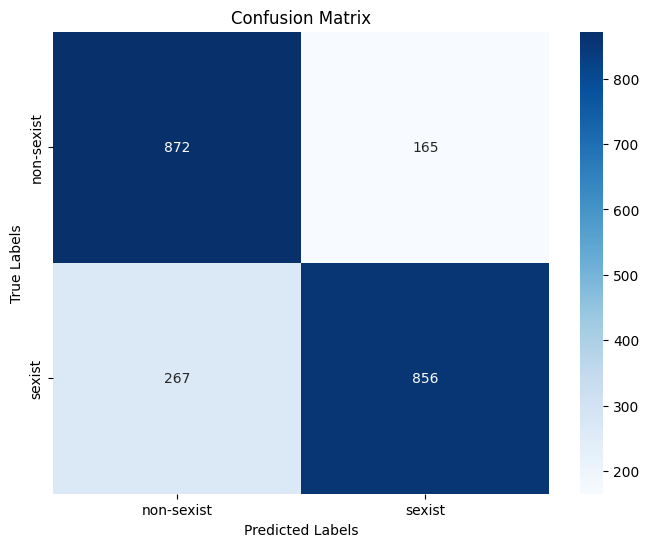

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las predicciones en el conjunto de pruebas
predictions = trainer.predict(tokenized_ds["test"]).predictions
predicted_labels = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del conjunto de pruebas
true_labels = tokenized_ds["test"]["label"]

# Calcular la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)

# Mostrar la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


#**Resultados**

---
Es necesario adaptar el dataset a las exisgencias del modelo. Cambiar el nombre de la clase objetivo y convertir los valores de formato strng a int.
Utilizando el modelo preentrenado [Robertutiio](https://huggingface.co/pysentimiento/robertuito-base-cased) x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español.

##<font color='brown'>**Train**</font>

```
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
{'eval_loss': 0.8809642195701599, 'eval_f1': 0.5315206298539316, 'eval_recall': 0.5056654596730847, 'eval_runtime': 3.4558, 'eval_samples_per_second': 205.16, 'eval_steps_per_second': 25.753, 'epoch': 1.0}
{'eval_loss': 0.816580057144165, 'eval_f1': 0.5959356783733845, 'eval_recall': 0.5740393540718135, 'eval_runtime': 3.43, 'eval_samples_per_second': 206.706, 'eval_steps_per_second': 25.948, 'epoch': 2.0}
{'eval_loss': 0.9064635038375854, 'eval_f1': 0.6154138379624038, 'eval_recall': 0.5966786685260929, 'eval_runtime': 3.2736, 'eval_samples_per_second': 216.579, 'eval_steps_per_second': 27.187, 'epoch': 3.0}
{'eval_loss': 1.0341873168945312, 'eval_f1': 0.6231203840159453, 'eval_recall': 0.6308207181242749, 'eval_runtime': 3.3595, 'eval_samples_per_second': 211.046, 'eval_steps_per_second': 26.492, 'epoch': 4.0}
{'eval_loss': 1.044889211654663, 'eval_f1': 0.6251899235870882, 'eval_recall': 0.61380740846886, 'eval_runtime': 3.3521, 'eval_samples_per_second': 211.512, 'eval_steps_per_second': 26.551, 'epoch': 5.0}
{'train_runtime': 278.9422, 'train_samples_per_second': 50.763, 'train_steps_per_second': 1.595, 'train_loss': 0.4916371549113413, 'epoch': 5.0}
TrainOutput(global_step=445, training_loss=0.4916371549113413, metrics={'train_runtime': 278.9422, 'train_samples_per_second': 50.763, 'train_steps_per_second': 1.595, 'train_loss': 0.4916371549113413, 'epoch': 5.0})
```
##<font color='brown'>**Evaluación**</font>

```
{'eval_loss': 1.2399922609329224, 'eval_f1': 0.5807876452470078, 'eval_recall': 0.5478841484376831, 'eval_runtime': 11.9175, 'eval_samples_per_second': 181.247, 'eval_steps_per_second': 22.656, 'epoch': 5.0}
{'eval_loss': 1.2399922609329224,
 'eval_f1': 0.5807876452470078,
 'eval_recall': 0.5478841484376831,
 'eval_runtime': 11.9175,
 'eval_samples_per_second': 181.247,
 'eval_steps_per_second': 22.656,
 'epoch': 5.0}
```





**Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español y task1.**

##<font color='brown'>**Train**</font>



```
{'eval_loss': 0.4176936149597168, 'eval_f1': 0.82174555032325, 'eval_recall': 0.8229082111763676, 'eval_runtime': 3.9541, 'eval_samples_per_second': 179.308, 'eval_steps_per_second': 22.508, 'epoch': 1.0}
{'eval_loss': 0.42775365710258484, 'eval_f1': 0.815209195072988, 'eval_recall': 0.8154236101163475, 'eval_runtime': 6.7829, 'eval_samples_per_second': 104.527, 'eval_steps_per_second': 13.121, 'epoch': 2.0}
{'eval_loss': 0.5745871663093567, 'eval_f1': 0.8106394004624093, 'eval_recall': 0.8115121997803563, 'eval_runtime': 3.318, 'eval_samples_per_second': 213.686, 'eval_steps_per_second': 26.824, 'epoch': 3.0}
{'eval_loss': 0.7095562219619751, 'eval_f1': 0.8025383942070502, 'eval_recall': 0.8026309506756435, 'eval_runtime': 3.3712, 'eval_samples_per_second': 210.31, 'eval_steps_per_second': 26.4, 'epoch': 4.0}
{'eval_loss': 0.7335618138313293, 'eval_f1': 0.8081801543725631, 'eval_recall': 0.8082732496140317, 'eval_runtime': 3.3614, 'eval_samples_per_second': 210.924, 'eval_steps_per_second': 26.477, 'epoch': 5.0}
{'train_runtime': 286.882, 'train_samples_per_second': 49.358, 'train_steps_per_second': 1.551, 'train_loss': 0.19939609484726123, 'epoch': 5.0}
TrainOutput(global_step=445, training_loss=0.19939609484726123, metrics={'train_runtime': 286.882, 'train_samples_per_second': 49.358, 'train_steps_per_second': 1.551, 'train_loss': 0.19939609484726123, 'epoch': 5.0})
```
##<font color='brown'>**Evaluación**</font>


```
{'eval_loss': 0.935376763343811, 'eval_f1': 0.7887568619275936, 'eval_recall': 0.7911383872410912, 'eval_runtime': 12.0511, 'eval_samples_per_second': 179.237, 'eval_steps_per_second': 22.405, 'epoch': 5.0}
{'eval_loss': 0.935376763343811,
 'eval_f1': 0.7887568619275936,
 'eval_recall': 0.7911383872410912,
 'eval_runtime': 12.0511,
 'eval_samples_per_second': 179.237,
 'eval_steps_per_second': 22.405,
 'epoch': 5.0}
```




**Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español,task1, sin preprocesamiento y reduciendo batch_size = 16**

##<font color='brown'>**Train**</font>


```
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 [885/885 05:25, Epoch 5/5]
Epoch	Training Loss	Validation Loss	F1	Recall
1	No log	0.427899	0.809099	0.809077
2	No log	0.494435	0.809683	0.812189
3	0.314600	0.809876	0.809373	0.810151
4	0.314600	1.020675	0.810835	0.810756
5	0.314600	1.021207	0.813792	0.813792
TrainOutput(global_step=885, training_loss=0.18647011848492812, metrics={'train_runtime': 325.8376, 'train_samples_per_second': 43.457, 'train_steps_per_second': 2.716, 'total_flos': 920132249475840.0, 'train_loss': 0.18647011848492812, 'epoch': 5.0})
```
##<font color='brown'>**Evaluación**</font>



```
{'eval_loss': 1.2259948253631592,
 'eval_f1': 0.7850877155362814,
 'eval_recall': 0.7872811066239263,
 'eval_runtime': 13.0904,
 'eval_samples_per_second': 165.006,
 'eval_steps_per_second': 20.626,
 'epoch': 5.0}
```




**Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español,task1, sin preprocesamiento, añdiendo los tweets en inglés traducidos als español y reduciendo batch_size = 16**

# Train



```
Epoch	Training Loss	Validation Loss	F1	Recall
1	No log	0.452973	0.797775	0.797721
2	0.437700	0.603845	0.779150	0.779111
3	0.155100	1.225784	0.765031	0.765226
4	0.155100	1.459956	0.773834	0.773907
5	0.028200	1.535732	0.769324	0.769344
TrainOutput(global_step=1745, training_loss=0.1791297105116967, metrics={'train_runtime': 688.3193, 'train_samples_per_second': 40.541, 'train_steps_per_second': 2.535, 'total_flos': 1830442028810760.0, 'train_loss': 0.1791297105116967, 'epoch': 5.0})
```

#Evaluación



```
{'eval_loss': 1.4580191373825073,
 'eval_f1': 0.782227984476236,
 'eval_recall': 0.7847943112839197,
 'eval_runtime': 13.399,
 'eval_samples_per_second': 161.207,
 'eval_steps_per_second': 20.151,
 'epoch': 5.0}
```



**Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español,task1, con preprocesamiento, añadiendo los tweets en inglés traducidos al español y reduciendo batch_size = 16**

#Train


```
{'eval_loss': 0.46306246519088745, 'eval_f1': 0.7856132127560457, 'eval_recall': 0.7855667775177567, 'eval_runtime': 7.4273, 'eval_samples_per_second': 187.956, 'eval_steps_per_second': 23.562, 'epoch': 1.0}
{'loss': 0.4313, 'learning_rate': 3.567335243553009e-05, 'epoch': 1.43}
{'eval_loss': 0.622553825378418, 'eval_f1': 0.7729197230488031, 'eval_recall': 0.7729831260007389, 'eval_runtime': 7.3441, 'eval_samples_per_second': 190.085, 'eval_steps_per_second': 23.829, 'epoch': 2.0}
{'loss': 0.1631, 'learning_rate': 2.1346704871060173e-05, 'epoch': 2.87}
{'eval_loss': 1.1996393203735352, 'eval_f1': 0.7633533672368624, 'eval_recall': 0.7640883524243545, 'eval_runtime': 7.6693, 'eval_samples_per_second': 182.024, 'eval_steps_per_second': 22.818, 'epoch': 3.0}
{'eval_loss': 1.4765957593917847, 'eval_f1': 0.7721833913230902, 'eval_recall': 0.7724227121566696, 'eval_runtime': 7.4457, 'eval_samples_per_second': 187.491, 'eval_steps_per_second': 23.504, 'epoch': 4.0}
{'loss': 0.0297, 'learning_rate': 7.020057306590258e-06, 'epoch': 4.3}
{'eval_loss': 1.5640625953674316, 'eval_f1': 0.7671889905074478, 'eval_recall': 0.7672517140862997, 'eval_runtime': 7.4214, 'eval_samples_per_second': 188.105, 'eval_steps_per_second': 23.581, 'epoch': 5.0}
{'train_runtime': 649.4123, 'train_samples_per_second': 42.97, 'train_steps_per_second': 2.687, 'train_loss': 0.17986209699964115, 'epoch': 5.0}
TrainOutput(global_step=1745, training_loss=0.17986209699964115, metrics={'train_runtime': 649.4123, 'train_samples_per_second': 42.97, 'train_steps_per_second': 2.687, 'train_loss': 0.17986209699964115, 'epoch': 5.0})
```
#Evaluación


```
{'eval_loss': 1.3194084167480469, 'eval_f1': 0.7933893868853219, 'eval_recall': 0.7957753675021532, 'eval_runtime': 11.6127, 'eval_samples_per_second': 186.003, 'eval_steps_per_second': 23.25, 'epoch': 5.0}
{'eval_loss': 1.3194084167480469,
 'eval_f1': 0.7933893868853219,
 'eval_recall': 0.7957753675021532,
 'eval_runtime': 11.6127,
 'eval_samples_per_second': 186.003,
 'eval_steps_per_second': 23.25,
 'epoch': 5.0}
```




**Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español,task1, con preprocesamiento, añadiendo los tweets en inglés traducidos al español, añadiendo datos mediante técnica swapping y reduciendo batch_size = 16**

#Train


```
{'loss': 0.4287, 'learning_rate': 4.231950844854071e-05, 'epoch': 0.77}
{'eval_loss': 0.28115761280059814, 'eval_f1': 0.8863093429464013, 'eval_recall': 0.886421469577369, 'eval_runtime': 13.4422, 'eval_samples_per_second': 193.718, 'eval_steps_per_second': 24.252, 'epoch': 1.0}
{'loss': 0.2045, 'learning_rate': 3.4639016897081416e-05, 'epoch': 1.54}
{'eval_loss': 0.3857676088809967, 'eval_f1': 0.9105221546638917, 'eval_recall': 0.9108624938625978, 'eval_runtime': 15.3656, 'eval_samples_per_second': 169.469, 'eval_steps_per_second': 21.216, 'epoch': 2.0}
{'loss': 0.0899, 'learning_rate': 2.6958525345622122e-05, 'epoch': 2.3}
{'eval_loss': 0.5143325924873352, 'eval_f1': 0.9143214666856115, 'eval_recall': 0.9142899969785097, 'eval_runtime': 13.4567, 'eval_samples_per_second': 193.51, 'eval_steps_per_second': 24.226, 'epoch': 3.0}
{'loss': 0.0351, 'learning_rate': 1.927803379416283e-05, 'epoch': 3.07}
{'loss': 0.0093, 'learning_rate': 1.1597542242703534e-05, 'epoch': 3.84}
{'eval_loss': 0.5632923245429993, 'eval_f1': 0.9196407253709283, 'eval_recall': 0.9194076462590173, 'eval_runtime': 13.5603, 'eval_samples_per_second': 192.031, 'eval_steps_per_second': 24.041, 'epoch': 4.0}
{'loss': 0.0049, 'learning_rate': 3.9170506912442395e-06, 'epoch': 4.61}
{'eval_loss': 0.5831766724586487, 'eval_f1': 0.9166516092194943, 'eval_recall': 0.9167638422026665, 'eval_runtime': 13.4608, 'eval_samples_per_second': 193.45, 'eval_steps_per_second': 24.218, 'epoch': 5.0}
{'train_runtime': 1195.97, 'train_samples_per_second': 43.538, 'train_steps_per_second': 2.722, 'train_loss': 0.11896813933933569, 'epoch': 5.0}
TrainOutput(global_step=3255, training_loss=0.11896813933933569, metrics={'train_runtime': 1195.97, 'train_samples_per_second': 43.538, 'train_steps_per_second': 2.722, 'train_loss': 0.11896813933933569, 'epoch': 5.0})
```
#Evaluación



```
{'eval_loss': 1.4832550287246704, 'eval_f1': 0.7999890254609306, 'eval_recall': 0.8015655819281422, 'eval_runtime': 11.5343, 'eval_samples_per_second': 187.268, 'eval_steps_per_second': 23.408, 'epoch': 5.0}
{'eval_loss': 1.4832550287246704,
 'eval_f1': 0.7999890254609306,
 'eval_recall': 0.8015655819281422,
 'eval_runtime': 11.5343,
 'eval_samples_per_second': 187.268,
 'eval_steps_per_second': 23.408,
 'epoch': 5.0}
```




Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español y task2. Hemos incorporado los tweets en inglés, que han sido traducidos al español.

#Train


```
{'eval_loss': 0.9190000295639038, 'eval_f1': 0.5901528860406369, 'eval_recall': 0.5957352086839005, 'eval_runtime': 7.1185, 'eval_samples_per_second': 196.108, 'eval_steps_per_second': 24.584, 'epoch': 1.0}
{'eval_loss': 0.9517709612846375, 'eval_f1': 0.5928994506981274, 'eval_recall': 0.5779724549259689, 'eval_runtime': 7.0092, 'eval_samples_per_second': 199.167, 'eval_steps_per_second': 24.967, 'epoch': 2.0}
{'loss': 0.6948, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.86}
{'eval_loss': 1.1642926931381226, 'eval_f1': 0.568597598367809, 'eval_recall': 0.5460934733420615, 'eval_runtime': 7.1272, 'eval_samples_per_second': 195.869, 'eval_steps_per_second': 24.554, 'epoch': 3.0}
{'eval_loss': 1.3256367444992065, 'eval_f1': 0.5913884118946812, 'eval_recall': 0.5850167324387883, 'eval_runtime': 7.0329, 'eval_samples_per_second': 198.497, 'eval_steps_per_second': 24.883, 'epoch': 4.0}
{'eval_loss': 1.4387211799621582, 'eval_f1': 0.5917159869995268, 'eval_recall': 0.5769648662601905, 'eval_runtime': 7.3845, 'eval_samples_per_second': 189.044, 'eval_steps_per_second': 23.698, 'epoch': 5.0}
{'train_runtime': 583.1049, 'train_samples_per_second': 47.856, 'train_steps_per_second': 1.501, 'train_loss': 0.44934688895089286, 'epoch': 5.0}
TrainOutput(global_step=875, training_loss=0.44934688895089286, metrics={'train_runtime': 583.1049, 'train_samples_per_second': 47.856, 'train_steps_per_second': 1.501, 'train_loss': 0.44934688895089286, 'epoch': 5.0})
```
#Evaluación



```
{'eval_loss': 1.4549012184143066, 'eval_f1': 0.5479621072679599, 'eval_recall': 0.5208229176396909, 'eval_runtime': 13.013, 'eval_samples_per_second': 165.988, 'eval_steps_per_second': 20.749, 'epoch': 5.0}
{'eval_loss': 1.4549012184143066,
 'eval_f1': 0.5479621072679599,
 'eval_recall': 0.5208229176396909,
 'eval_runtime': 13.013,
 'eval_samples_per_second': 165.988,
 'eval_steps_per_second': 20.749,
 'epoch': 5.0}
```




Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español y task2. Hemos incorporado los tweets en inglés, que han sido traducidos al español.Además se ha configurado learning_rate y weights_decay pero no hay mejora en relación a los resutados anteriores.

En la evaluación del modelo para el conjunto de test : eval_f1': 0.555182487114667,

Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español y task2. Hemos incorporado los tweets en inglés, que han sido traducidos al español.Además se ha configurado weights_decay= 0.001 y dropout de 0.2 pero no hay mejora en relación a los resutados anteriores.

En la evaluación del modelo para el conjunto de test eval_f1': 0.5811604818154509


Utilizando el modelo preentrenado Robertutio x defecto sin ninguna capa, configuración adicional sobre un conjunto de datos en idioma español y task2. Hemos incorporado los tweets en inglés, que han sido traducidos al español.No se ha preprocesado los datos Pero no hay mejora en relación a los resutados anteriores.

En la evaluación del modelo para el conjunto de test
'eval_f1': 0.5633417329073163,